In [5]:
import sympy as sy
import numpy as np
from matplotlib import pyplot as plt

In [16]:
# ORIGINAL PARAMETERS #

p = 8.3e-5 #'' # units mup1 per millisecond (mup1 production rate)
w = 32 # unitless (scale factor for pH difference)
j = 100 #'' # per millisecond (methionine unbinding rate)
kd = 8993 # (methionine dissociation constant)
h = j / kd #'' # per micromolar per millisecond (methionine binding rate)
f = .25 #'' # per millisecond (recycling rate)
Ae = 47 # micrometers^3 (endosomal membrane surface area)
Ap = 314 # micrometers^3 (plasma membrane surface area)
u = 1 # per millisecond (ubiquitination rate)
a = 10 #'' # per micromolar per millisecond (art 1 binding rate)
b = 1 # per millisecond (deubiquitination rate)
d = .002 #'' # per millisecond (degradation rate)
n = 0.1 #'' # per millisecond (endocytosis rate)
V = 523 # micrometers^3 (volume of cytoplasm)
vmax = 174333.33 # micromolars*micrometers^3 per millisecond (maximal rate of methionine metabolism)
        # can range from 0 to infty
Km = 350 #'' # micromolars (methionin michaelis-menten constant)
# vmax = 8.8e3
# Km = 2.5
Me = .1


In [4]:
"""OLD PARAMETERS"""

# parameters (filled in the ones I think would be the same or similar to Fur4)
p = 8.3e-5 #'' # units mup1 per millisecond (mup1 production rate)
h = 135 #'' # per micromolar per millisecond (methionine binding rate)
w = 32 # unitless (scale factor for pH difference)
j = 100 #'' # per millisecond (methionine unbinding rate)
f = .25 #'' # per millisecond (recycling rate)
Ae = 47 # micrometers^3 (endosomal membrane surface area)
Ap = 314 # micrometers^3 (plasma membrane surface area)
u = 1 # per millisecond (ubiquitination rate)
a = 135 #'' # per micromolar per millisecond (art 1 binding rate)
b = 1 # per millisecond (deubiquitination rate)
d = .002 #'' # per millisecond (degradation rate)
n = 0.1 #'' # per millisecond (endocytosis rate)
V = 523 # micrometers^3 (volume of cytoplasm)
vmax = 8.8e3 #'' # micromolars*micrometers^3 per millisecond (maximal rate of methionine metabolism)
Km = 2.5 #'' # micromolars (methionine michaelis-menten constant)
Me = 1

In [12]:
# change a parameter
vmax = 174333.33
Km = 350

In [17]:
# substitution into M to get equation for bisection method

# establish sympy variables
P, Pm, Pa, Pu, E, Em, Ea, Eu, M = sy.symbols("P, Pm, Pa, Pu, E, Em, Ea, Eu, M")

# steady states computed previously
steady_states = {P : p*w*(M*a**2*d*h + M*a*d*h*j + a**2*b*f*w + a**2*d*f*w + 2*a*b*f*j*w + 2*a*d*f*j*w + b*f*j**2*w + d*f*j**2*w)/(M*a**2*d*h**2*(M + Me*w)),
                 Pm : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a**2*d*h),
                 Pa : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a*d*h*u),
                 Pu : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a*d*h*n),
                 E : Ap*p*w*(a*b + a*d + b*j + d*j)/(Ae*M*a*d*h),
                 Em : Ap*p*(b + d)/(Ae*a*d),
                 Ea : Ap*p*(b + d)/(Ae*d*u),
                 Eu : Ap*p/(Ae*d)}

# substitutions
dM = -(h/w)*M*((Ap / V)*P + (Ae / V)*E) + (j + u)*((Ae / V)*Em + (Ap / V)*Pm) - vmax*M/(V*(Km + M))  # M 

new_dM = dM.subs(steady_states)
new_dM = sy.simplify(new_dM)
new_dM

(-174345.1048116*M**3 - 655022.951658992*M**2 - 29222614.9945766*M + 1168885922.77476)/(M*(523.0*M**2 + 184723.6*M + 585760.0))

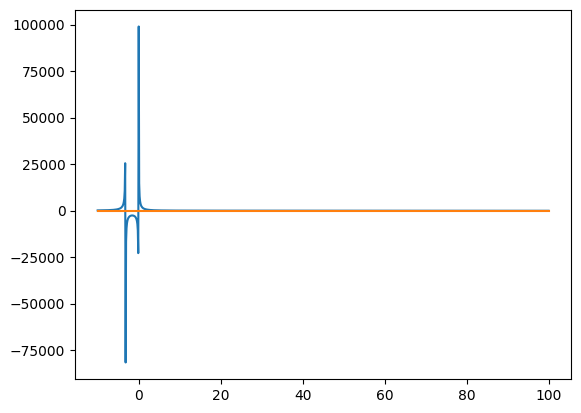

In [18]:
dM_func = sy.lambdify(M, new_dM)

# plot dM against M
x_vals = np.linspace(-10, 100, 1000)
plt.plot(x_vals, dM_func(x_vals))
plt.plot(x_vals, np.zeros_like(x_vals))
# plt.ylim(-10, 10)
plt.show()

In [4]:
"""Define the model"""
from mup1_model import bisection_M

def mup1_model(t, y, parameters):
    """Function coding the Mup1 trafficking model.
    
        Parameters:
        - y (array, list): values of P, Pm, Pa, Pu, E, Em, Ea, Eu, M"""

    P, Pm, Pa, Pu, E, Em, Ea, Eu, M = y 
    p, w, j, kd, f, Ae, Ap, u, a, b, d, n, V, vmax, Km, Me = parameters    # unpack for readability
    h = j / kd

    # define the differential equations
    dy = [
        p - h*Me*P - (h/w)*M*P + j*Pm + f*(Ae/Ap)*E,                       # P
        h*Me*P + (h/w)*M*P - j*Pm - a*Pm,                                  # Pm
        a*Pm - u*Pa,                                                       # Pa
        u*Pa - n*Pu,                                                       # Pu
        n*(Ap/Ae)*Pu - f*E + b*Eu - (h/w)*E*M + j*Em,                      # E
        (h/w)*E*M - a*Em - j*Em,                                           # Em
        a*Em - u*Ea,                                                       # Ea
        -b*Eu + u*Ea - d*Eu,                                               # Eu
        -(h/w)*M*((Ap / V)*P + (Ae / V)*E) + (j + u)*((Ae / V)*Em + (Ap / V)*Pm) - vmax*M/(V*(Km + M))  # M 
        ]

    return dy

def mup1_steady_states(parameters):
    """Function to find the steady states of the Mup1 trafficking model.
    
        Parameters:
        - parameters (array, list): values of the parameters"""
    p, w, j, kd, h, f, Ae, Ap, u, a, b, d, n, V, vmax, Km, Me = parameters    # unpack for readability
    M = bisection_M(Me)

    steady_states = {'P' : p*w*(M*a**2*d*h + M*a*d*h*j + a**2*b*f*w + a**2*d*f*w + 2*a*b*f*j*w + 2*a*d*f*j*w + b*f*j**2*w + d*f*j**2*w)/(M*a**2*d*h**2*(M + Me*w)),
                    'Pm' : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a**2*d*h),
                    'Pa' : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a*d*h*u),
                    'Pu' : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a*d*h*n),
                     'E' : Ap*p*w*(a*b + a*d + b*j + d*j)/(Ae*M*a*d*h),
                    'Em' : Ap*p*(b + d)/(Ae*a*d),
                    'Ea' : Ap*p*(b + d)/(Ae*d*u),
                    'Eu' : Ap*p/(Ae*d)}
    

    return sum(steady_states.values()) + M

In [5]:
"""AI suggested parameter ranges"""

parameter_ranges = [
    [8.3e-6, 8.3e-4],     # p: Mup1 production rate – production rates can vary over orders of magnitude due to transcriptional and translational regulation, environmental cues, and promoter strength.
    [10, 100],            # w: pH scale factor – this is a unitless scaling factor, and while its exact biological interpretation may vary, a range of 1 order of magnitude allows for exploratory analysis without being too speculative.
    [10, 1000],           # j: Methionine unbinding rate – binding and unbinding kinetics often vary by 1–2 orders of magnitude depending on temperature, affinity, and conformational state.
    [1000, 90000],        # kd: Dissociation constant – dissociation constants vary widely across protein-ligand systems; range chosen to reflect affinities from high (1 μM) to low (90 μM) binding strength.
    # h is derived from j/kd, so it should not be varied independently – vary j and kd instead
    [0.025, 2.5],         # f: Recycling rate – endosomal recycling rates can vary depending on the type of cargo, regulatory proteins, and metabolic state; 1 order of magnitude captures plausible biological fluctuation.
    [20, 100],            # Ae: Endosomal surface area – endosomal sizes (and hence surface areas) differ based on maturation stage and cell size; this range allows for ~5x variation while remaining realistic for yeast cells.
    [100, 1000],          # Ap: Plasma membrane surface area – reflects variability in yeast cell size; 3–10 μm diameter cells yield surface areas within this range.
    [0.1, 10],            # u: Ubiquitination rate – enzymatic tagging rates are context-dependent, influenced by E3 ligase concentration and substrate type; range spans 2 orders of magnitude.
    [1, 100],             # a: Art1 binding rate – ART protein interactions with transporters can vary widely depending on substrate conformation and signaling state; large range allows for nonlinearity exploration.
    [0.1, 10],            # b: Deubiquitination rate – affected by availability of deubiquitinases and substrate accessibility; same logic as for ubiquitination rate.
    [0.0002, 0.02],       # d: Degradation rate – protein degradation is generally slow, but this range captures variation due to stress conditions, proteasome targeting, or trafficking dynamics.
    [0.01, 1],            # n: Endocytosis rate – strongly regulated and responsive to signaling, nutrient levels, and surface cargo density; up to 100-fold variability is plausible.
    [200, 1000],          # V: Cytoplasmic volume – yeast cells range from ~30 to ~100 fL; cytoplasmic volume varies with cell cycle stage and environmental conditions.
    [1e4, 1e6],           # vmax: Max methionine metabolism rate – reflects possible differences in metabolic enzyme expression, post-translational regulation, and methionine flux capacity.
    [50, 1000],           # Km: Michaelis constant – Km values commonly vary across enzymes and contexts; this range includes both high-affinity (low Km) and low-affinity (high Km) scenarios.
    [0.1, 500],           # Me: Extracellular methionine concentration – based on reported yeast media compositions (from starvation up to rich media); range spans near-zero to saturating conditions.
]


In [3]:
"""Parameter Sensitivity Analysis"""
from SALib.sample import saltelli, sobol as sobol_sample
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm

# set up problem
problem = {
    'num_vars': 15,
    'names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km'],
    'bounds': parameter_ranges
}

# generate samples using Saltelli sampler
param_values = sobol_sample.sample(problem, 128)

# loop over sample inputs and run model
Y = np.zeros([param_values.shape[0]])

# set up for use with solve_ivp
# Choose initial conditions
y0 = [0, 0, 0, 0, 0, 0, 0, 0, 0]

# Time span for integration
t_span = (0, 50)
t_eval = np.linspace(*t_span, 10)

for i, X in enumerate(tqdm(param_values, desc="Running model")):
    sol = solve_ivp(mup1_model, t_span, y0, args=(X,), t_eval=t_eval)
    # have it save the total amount of mup1
    Y[i] = sum(sol.y[:, -1])

# compute sensitivity indices using model outputs
Si = sobol.analyze(problem, Y)

Si.plot()
plt.show()


Running model:   0%|          | 0/4352 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 17, got 16)

In [ ]:
# Store results in a list
results = [{'timestamp': '2025-06-19T10:56:32.497337', 
            'seed': None, 
            'sensitivity_indices': {'mu': [1.0978665942541703, 1.0851931734006008e-06, 0.10479488942297797, -2.0159325680521616, -0.02143248250496083, -0.06098611003412613, 0.09686167308559247, 0.03180786520859847, -0.9226258646638608, 0.00021498965720665318, -3.600319016334209e-07, 0.13047729381061474, -0.6726308265287009, -0.8000933948624768, 0.048257237183364825, 0.3995054573371986], 
                                    'mu_star': [1.0978665942541703, 1.2301721229335192e-06, 0.10479488942297797, 2.0159325680521616, 0.07812901498637817, 0.06098611003412613, 0.09686167308559247, 0.03180787210638027, 0.953622000030093, 0.00021671975505486093, 3.6003190173261525e-07, 0.13047729381061474, 0.6726308856602912, 0.8000933948624768, 0.048257237183364825, 0.3995054573371986], 
                                    'mu_star_conf': [1.8560658552228189, 1.0426458267263852e-06, 0.08413171401420166, 3.516662325164585, 0.05449786359560706, 0.03801589357785989, 0.07880390390026773, 0.04271226218838121, 0.9927790876622197, 0.0004414706910871279, 5.212200080096482e-07, 0.1473433265243125, 1.196185022560689, 1.2025414901538014, 0.050796908879682204, 0.5830165284585572], 
                                    'sigma': [5.460744469127985, 3.539567080219277e-06, 0.24858564292972013, 10.93683669948031, 0.17512174815517237, 0.12266518552045458, 0.23521785638238882, 0.14450626350236215, 3.3412453826989057, 0.001220990982578263, 1.4294729151248763e-06, 0.38848594738373055, 3.641157064112175, 3.7042698486163257, 0.13716212329720298, 1.5487152591378874]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:02:44.961774', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.31983105189826205, -9.428424072137614e-09, 0.13221482359512826, -1.7153830457095713, 0.7254595879542716, -0.08136941739330167, 0.6103514169594899, 0.3219758914090119, -0.2547668184042228, 1.8802851876752057e-06, -6.777149410754022e-07, 0.11816543928288693, -0.4657664869336063, -0.9240703157803625, 0.4954128093821484, 0.31953617516427635], 
                                     'mu_star': [0.31983105189826205, 1.3248259010026642e-07, 0.13221482957630018, 1.7153830994435006, 0.748691338645769, 0.08136941739330167, 0.610351514025209, 0.3219759345264019, 0.25869167197877335, 1.9059465174101722e-06, 6.77714941076378e-07, 0.11816543928288693, 0.4657667142238671, 0.9240703157803625, 0.4954128093821484, 0.31953617516427635], 
                                     'mu_star_conf': [0.29839841139121925, 9.434374366864377e-08, 0.12813890820903406, 1.9134218932889966, 1.2119405963419287, 0.07207551649243221, 0.5913971004901549, 0.48417965552980124, 0.21079175531741032, 2.817144198140066e-06, 8.934828028459809e-07, 0.10872576876536375, 0.7169361841870913, 0.9780848719248992, 0.5417093414121895, 0.4929582593577602], 
                                     'sigma': [0.9157109779089438, 3.034295663909402e-07, 0.3576634050927632, 5.589892638480653, 3.4218579818512675, 0.21143723241274423, 1.7583561767271865, 1.520380237239274, 0.6400938993409814, 7.954463897136222e-06, 2.5730563828413196e-06, 0.29931342200004785, 1.9461208231984486, 2.7882601615535565, 1.5701501235358872, 1.3257011277942607]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:06:25.313279', 
            'seed': None, 
            'sensitivity_indices': {'mu': [1.8194588664970819, 8.431443746488059e-06, 0.34599965500489677, -0.643715298746547, 0.27398941551104034, -0.03144335800444942, 2.0130255979493588, 0.020617183972674195, -0.23283703282560497, 6.375280874770364e-07, -2.47522350481536e-06, 0.15266827579014933, -0.531375190742546, -0.48932747872230015, 1.6829212035956647, 0.38424565887062545], 
                                     'mu_star': [1.8194588664970819, 8.44958878814465e-06, 0.3459996804868605, 0.643715298746547, 0.3273545742225071, 0.03144335800444942, 2.01302565541379, 0.020617247931852788, 0.2688024138819368, 7.143518521669753e-07, 2.4752235048169863e-06, 0.15266827579014933, 0.5313756360843104, 0.48932747872230015, 1.6829212035956647, 0.38424565887062545], 
                                     'mu_star_conf': [3.1208143073192525, 1.3630107070940413e-05, 0.5879297317796714, 0.9080752715924513, 0.48479560958572965, 0.021545456349141897, 3.902735280851506, 0.017049586926173914, 0.45878165844875834, 1.1160662996968532e-06, 4.602770758619781e-06, 0.17070328234123913, 1.0582980770037649, 0.5237828000248009, 2.1722558966810204, 0.4387857978671009], 
                                     'sigma': [8.1652228091954, 3.415875110437142e-05, 1.6043011774158131, 2.514815484149166, 1.5988425523323633, 0.07655521106577283, 10.607133468397961, 0.04843523542752808, 1.289322865100198, 3.2490665906982695e-06, 1.3408344288605674e-05, 0.48944830304948517, 2.9859051086171213, 1.5195467271817291, 6.364214508452977, 1.2639713353675217]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:10:18.959902', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.21311937270707323, 2.7938224547291997e-05, 0.13464903514642496, -0.07187266729903137, 0.01290728300230294, -0.02703070774455009, 0.14935225578185976, 0.04806273985312968, -0.06533902122053264, -4.307801474637432e-07, -1.2942687757473316e-06, 0.11883813107936995, -0.025711693607129056, -0.06612980708684453, 0.057950910361098174, 0.020350874477528924], 
                                    'mu_star': [0.21311937270707323, 3.204417452384711e-05, 0.13464905214601802, 0.07187266729903137, 0.08870677755315255, 0.02703070774455009, 0.14935225578185976, 0.048062744361392636, 0.08014917672569567, 9.416099069077743e-07, 1.294268775750874e-06, 0.11883813107936995, 0.02571190063037057, 0.06612980708684453, 0.05795091154985138, 0.020350874477528924], 
                                    'mu_star_conf': [0.13902759848400137, 6.106141784786861e-05, 0.16319455661082724, 0.03999678684006248, 0.10697569139447607, 0.022587030052531976, 0.15581032291569263, 0.032113948225430324, 0.08075071964329548, 1.2185544708788866e-06, 2.287835665078388e-06, 0.12119740478016809, 0.044872555689102395, 0.0515973864429127, 0.07565719337778563, 0.016419577149265806], 
                                    'sigma': [0.42039499159049554, 0.00017025641689799703, 0.4255244386641648, 0.11110834253438635, 0.3055527389929187, 0.07364577295109266, 0.4655238650595247, 0.11875951828238301, 0.22284251273481923, 3.843049955716379e-06, 6.840125610682236e-06, 0.3557721110188359, 0.13200479736153106, 0.17880271815925586, 0.19887135357601907, 0.044901444104377575]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:15:06.619242', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.3366677178858109, -9.480411441928248e-07, 0.20448576875816674, -0.08568745148831329, -0.07074511018648344, -0.021547598904024908, 0.1818507517603852, 0.021429691836765127, -0.007474819519016318, -2.168064403082453e-07, -1.0031695685120269e-08, 0.030487472162510333, -0.1267889115399116, -0.2206451252293507, 0.01615291822504427, 0.10367860476246084], 
                                    'mu_star': [0.3366677178858109, 1.1757647348656677e-06, 0.20448588544762883, 0.08568745148831329, 0.07102094204343615, 0.021547598904024908, 0.1818507517603852, 0.021429691836765127, 0.021260959261086045, 2.1920782649354552e-07, 1.0031695882949896e-08, 0.030487472162510333, 0.1267890463436038, 0.2206451383825676, 0.01615295455079494, 0.10367860476246084], 
                                    'mu_star_conf': [0.4598010178246977, 2.0993097351654347e-06, 0.3429684515139567, 0.11253003130322103, 0.052292632128896684, 0.015442126795252847, 0.1448281970000985, 0.016246152772654763, 0.018879483383918462, 3.3113630398074686e-07, 1.7476214519005306e-08, 0.020192683254596878, 0.237707363156445, 0.26701543695459534, 0.010281187882359896, 0.12059559587895355], 
                                    'sigma': [1.1305383180494601, 5.9968524198984915e-06, 0.9556326280929867, 0.33890476932830804, 0.14653092619545943, 0.04715115907194113, 0.4537589203413388, 0.04470838134524375, 0.05400576752863473, 9.882524603408787e-07, 5.026950601456642e-08, 0.05768951687206959, 0.6792753823265738, 0.7445403742617075, 0.02867825713772908, 0.3727054757161615]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:18:38.704511', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.9452520673798158, 0.00027300335298985606, 0.10810623781106388, -1.5302502765988708, 0.24313441225671775, -0.011715722364775931, 0.0847196500148812, 0.033390323036463686, -0.19734747839341618, -2.7246312565158338e-06, -1.885467991595556e-08, 0.059231788362391624, -0.1288163672403703, -0.6096369005039591, 0.6694586385479375, 0.7441472932752698], 
                                    'mu_star': [0.9452520673798158, 0.00027332221701576625, 0.10810623781106388, 1.5302502765988708, 0.42932839110232224, 0.011715722364775931, 0.0847196500148812, 0.033390323036463686, 0.20318437548532994, 2.7685642729252184e-06, 1.8854680093075232e-08, 0.059231788362391624, 0.1288166841050931, 0.6096369317552054, 0.6694586385479375, 0.7441472932752698], 
                                    'mu_star_conf': [1.261833573503595, 0.000506944732173422, 0.09725940322050296, 2.4909345769370974, 0.5873168052172267, 0.009323664428122599, 0.06238308362626871, 0.055144110132308286, 0.21928604424756853, 5.655519932903278e-06, 3.1796039061993334e-08, 0.07029142713515991, 0.28179725017194013, 0.6882390656346167, 1.0246846088239392, 1.139646726562858], 
                                    'sigma': [3.4080199465359433, 0.001533573488466367, 0.3085490447413247, 8.232150778366098, 1.8134510981577503, 0.027518021604283086, 0.1919706246984924, 0.13876855785530415, 0.6398720361756178, 1.5466466611097438e-05, 9.461584851170963e-08, 0.2115267565772344, 0.7055879983362989, 2.1001467702722545, 3.104047726717269, 3.3788080578646245]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:23:42.737828', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.1926638551612678, 1.3010998786973426e-06, 0.8837925226927582, -0.13151133355648711, -0.09404554237098667, -0.04096427947398792, 0.10969721641283621, 0.007685081203739609, -0.06438623638879101, -1.670330419279688e-09, -1.3153633702327418e-06, 0.03236029123508374, -0.6081711155750139, -1.4431099156507623, 0.09126123302054709, 0.0770276383599637], 
                                    'mu_star': [0.1926638551612678, 1.4850142021680376e-06, 0.8837925682843116, 0.13151133355648711, 0.09442943339035959, 0.04096427947398792, 0.10969721641283621, 0.007685081203739609, 0.0742447038007656, 3.7436108089676185e-08, 1.315363370232808e-06, 0.03236029123508374, 0.6081713929311388, 1.4431099235815243, 0.09126123302054709, 0.0770276383599637], 
                                    'mu_star_conf': [0.14666231395472587, 1.949466647861802e-06, 1.523384530780135, 0.12832026888091425, 0.10246218566632527, 0.0445472533026466, 0.06203664455072272, 0.008609179905234165, 0.08832603011026655, 4.434777520426161e-08, 1.8191208157057463e-06, 0.02504600711662673, 1.0067530091126664, 2.3074897949327027, 0.09787956077717105, 0.07890250565386132], 
                                    'sigma': [0.36990614105059827, 6.603484516831711e-06, 4.493888007343049, 0.3921574691521321, 0.2728483229442998, 0.13493467737000475, 0.1872635228232828, 0.025416846435483566, 0.26372940238788517, 1.4003125142297633e-07, 5.463700786404648e-06, 0.06896545515090725, 3.393408370744427, 7.795867345381479, 0.2730725083764207, 0.23049089364908082]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:27:30.278815', 
            'seed': None, 
            'sensitivity_indices': {'mu': [4.062157877830038, 0.11591378111468369, 0.058024774381124966, -0.04097110532678509, 2.827555954202775, -0.039934686381549865, 0.4990972692018712, 0.021815751407849707, -0.10493161999725044, 0.0010313422282713974, -6.276419277934758e-09, 0.6268631974638856, -0.9850571902338717, -0.07783666615387479, 0.09712589093187554, 0.20481094120749346], 
                                    'mu_star': [4.062157877830038, 0.11591393874916661, 0.058024774381124966, 0.04097110532678509, 3.0286522770968105, 0.039934686381549865, 0.4990972740432435, 0.021815751407849707, 0.15167175628502516, 0.0010313978207242768, 6.276419277934758e-09, 0.6268631974638856, 0.985057707722259, 0.0778367006923175, 0.09712589093187554, 0.20481094120749346], 
                                    'mu_star_conf': [7.3363915661220815, 0.2158509644793931, 0.05688346244625618, 0.02887485394653805, 5.327568818898924, 0.040116798666488464, 0.7243265710262249, 0.02306522161115873, 0.09789707659492458, 0.001922488704229746, 8.641449442839464e-09, 1.0289085340342572, 1.5869651673629448, 0.07258992327418574, 0.10211570182913951, 0.172797242228489], 
                                    'sigma': [21.274151581537982, 0.6554243241774107, 0.16725623089703165, 0.08923568325956253, 16.04592566223838, 0.11253918744560479, 2.094236271687441, 0.05952288609260199, 0.3508912573394261, 0.005793538657732685, 2.4595868155836425e-08, 2.735412599123648, 4.958767014207254, 0.23555531246602918, 0.3611881855326098, 0.5304276543401503]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:30:42.078291', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.3136028462921433, 4.7921246755369864e-05, 0.05024432461605674, -0.06629600278031635, -0.02278753324711151, -0.08126423702695866, 0.07035824125722845, 0.010732453601991269, -0.17305467680514933, -6.233147646937956e-08, -1.357656173108786e-08, 0.053860868345427554, -0.0057250908165759305, -0.31978309694822754, 0.1533873633027311, 0.1578475855541612], 
                                    'mu_star': [0.3136028462921433, 4.8382575428204155e-05, 0.05024441485924665, 0.06629608673833323, 0.041202703963426214, 0.08126423702695866, 0.07035824125722845, 0.010732541665393173, 0.18303230284544036, 7.428462276075903e-08, 1.357656173108786e-08, 0.053860868345427554, 0.0057253678179633545, 0.31978309694822754, 0.1533873633027311, 0.1578475855541612], 
                                    'mu_star_conf': [0.20851268972804457, 8.962208727846438e-05, 0.04255974815257316, 0.028543957206079745, 0.026405816088384187, 0.05146050700661526, 0.04451060567200631, 0.008290143573915908, 0.27187645731636617, 1.183374831337615e-07, 1.712663472802613e-08, 0.06445395201107686, 0.006740304356661083, 0.48817519778169455, 0.12519207828176715, 0.12199077812532036], 
                                    'sigma': [0.6248162831099164, 0.0002717360253381189, 0.1263732481476393, 0.09473134923417613, 0.08779945535088836, 0.1451822118464348, 0.14056228206602, 0.02206283241608968, 0.734352152374964, 3.6153856987155195e-07, 5.0862755832696056e-08, 0.21847700079232923, 0.019129918539214853, 1.308737649895251, 0.41018782019738775, 0.36075415540153394]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
            {'timestamp': '2025-06-19T11:34:59.111336', 
             'seed': None, 
             'sensitivity_indices': {'mu': [0.31897253556144783, 2.1335000171744053e-06, 0.18455233236567276, -1.1853187919312995, -0.015530042379512592, -0.0353694879519037, 0.2457729307775947, 0.05755088713917702, -0.3555704239704863, -4.731841440222762e-08, -3.8111461584533072e-06, 0.025516872944951578, -0.02274960510922645, -0.3606964661737582, 0.09898812012638006, 1.318152739812797], 
                                     'mu_star': [0.31897253556144783, 2.1842338414104193e-06, 0.18455233236567276, 1.1853187919312995, 0.03922205201421567, 0.0353694879519037, 0.24577296097139156, 0.05755088713917702, 0.380898228211234, 6.047708027383513e-08, 3.8111461584781897e-06, 0.025516872944951578, 0.022750010381005523, 0.3606964661737582, 0.09898812012638006, 1.318152739812797], 
                                     'mu_star_conf': [0.15753147027454936, 2.5587540229845194e-06, 0.17683278047683806, 2.070586604436306, 0.034540392461692916, 0.030287826897055267, 0.17477343407808107, 0.08136987891910501, 0.3483564870640739, 1.0311643875087934e-07, 7.71555334643885e-06, 0.017595171276260504, 0.020192669488620602, 0.2995942834221576, 0.11820682375284661, 1.884275230624758], 
                                     'sigma': [0.5235302437691592, 7.683653137763106e-06, 0.46533440219397393, 5.784037245579449, 0.10394931437306001, 0.08652546246063053, 0.5211300193418142, 0.22004804396346872, 0.9672344057772547, 2.9026387940662626e-07, 2.1426309333901282e-05, 0.05450615588726531, 0.06665064480433172, 0.8762126517554769, 0.3909397483618415, 6.017984637952225]}, 
             'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}]


Starting multiprocessing


Running model in parallel:   0%|          | 0/544 [00:00<?, ?it/s]

{'timestamp': '2025-06-19T11:34:59.111336', 'seed': None, 'sensitivity_indices': {'mu': [0.31897253556144783, 2.1335000171744053e-06, 0.18455233236567276, -1.1853187919312995, -0.015530042379512592, -0.0353694879519037, 0.2457729307775947, 0.05755088713917702, -0.3555704239704863, -4.731841440222762e-08, -3.8111461584533072e-06, 0.025516872944951578, -0.02274960510922645, -0.3606964661737582, 0.09898812012638006, 1.318152739812797], 'mu_star': [0.31897253556144783, 2.1842338414104193e-06, 0.18455233236567276, 1.1853187919312995, 0.03922205201421567, 0.0353694879519037, 0.24577296097139156, 0.05755088713917702, 0.380898228211234, 6.047708027383513e-08, 3.8111461584781897e-06, 0.025516872944951578, 0.022750010381005523, 0.3606964661737582, 0.09898812012638006, 1.318152739812797], 'mu_star_conf': [0.15753147027454936, 2.5587540229845194e-06, 0.17683278047683806, 2.070586604436306, 0.034540392461692916, 0.030287826897055267, 0.17477343407808107, 0.08136987891910501, 0.3483564870640739, 1.0

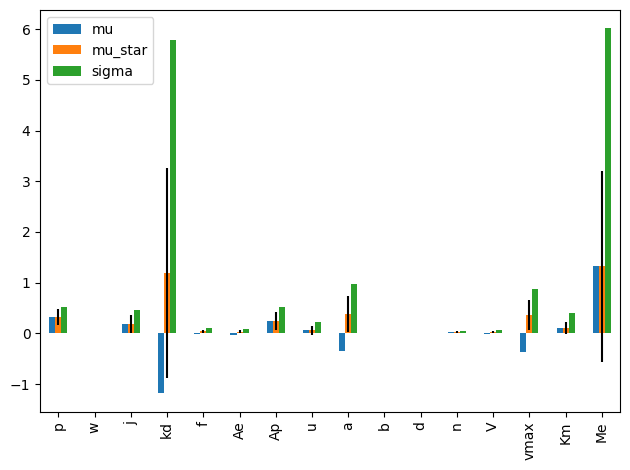

In [27]:
"""Trying it again using multiprocessing"""

from multiprocessing import Pool
from SALib.sample import sobol as sobol_sample, morris as morris_sample
from SALib.analyze import sobol, morris
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

# set up problem
problem = {
    'num_vars': 16,
    'names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me'],
    'bounds': parameter_ranges
}

# generate samples using Saltelli sampler
param_values = morris_sample.sample(problem, 32)

# loop over sample inputs and run model
Y = np.zeros([param_values.shape[0]])

def run_model(X):
    # set up for use with solve_ivp
    y0 = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    t_span = (0, 50)
    t_eval = np.linspace(*t_span, 10)
    
    sol = solve_ivp(mup1_model, t_span, y0, args=(X,), t_eval=t_eval)
    return sum(sol.y[:, -1])

print("Starting multiprocessing")
# Use multiprocessing to run the model in parallel
with Pool() as pool:
    # Use map instead of imap to maintain order
    Y = list(tqdm(pool.imap(run_model, param_values), 
                    total=len(param_values),
                    desc="Running model in parallel"))

# Convert to numpy array
Y = np.array(Y)

# compute sensitivity indices using model outputs
Si = morris.analyze(problem, param_values, Y)
results.append({'timestamp': datetime.now().isoformat(),
        'seed': None,
        'sensitivity_indices': {
            'mu': Si['mu'].tolist(),
            'mu_star': Si['mu_star'].tolist(),
            'mu_star_conf': Si['mu_star_conf'].tolist(),
            'sigma': Si['sigma'].tolist() if 'sigma' in Si else None,
        },
        'parameter_names': problem['names']})
print(results[-1])

Si.plot()
plt.tight_layout()
#plt.savefig("Images/sensitivity_analysis/morris_from_og_system_ai_params_3.png")
plt.show()



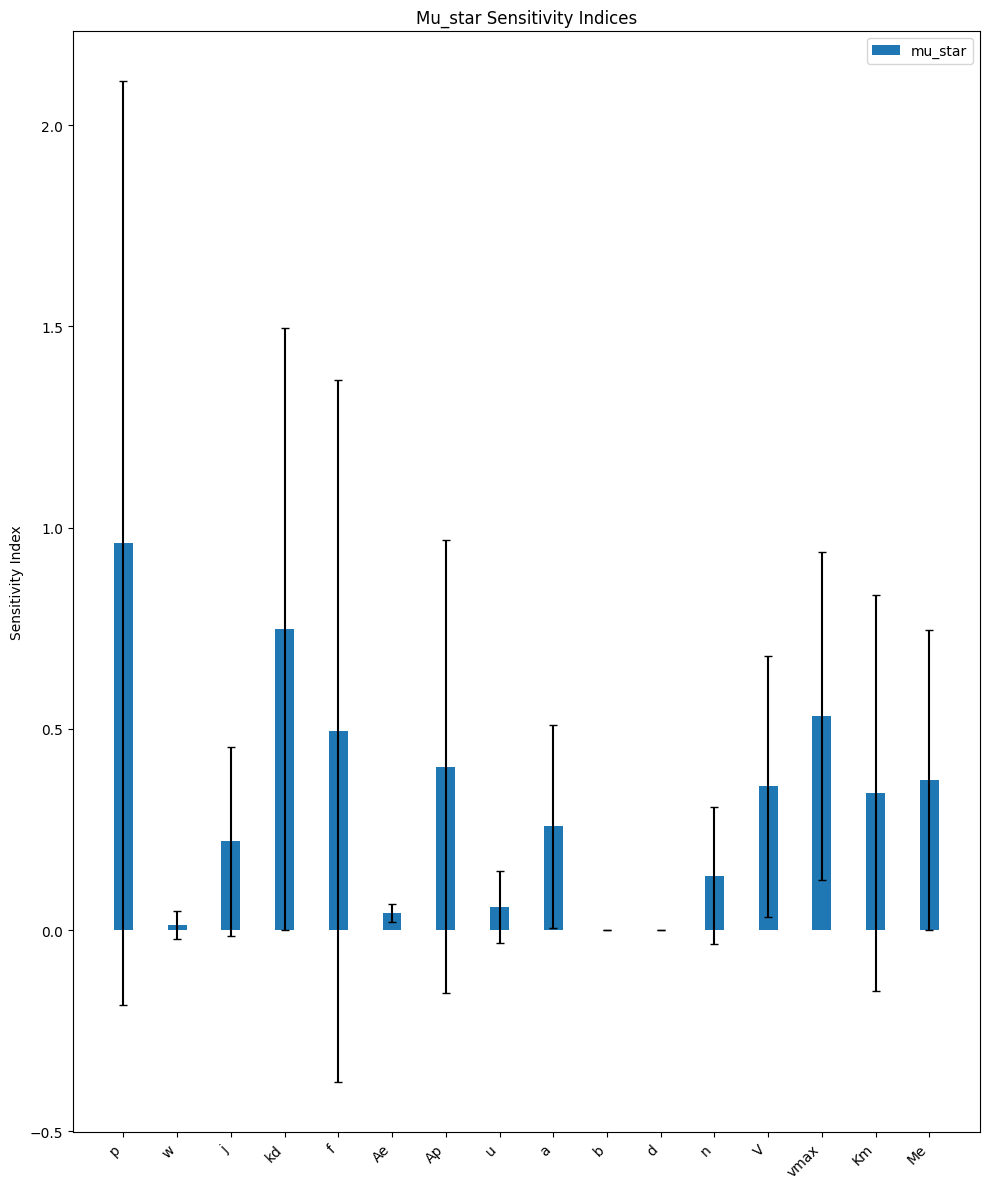

In [2]:
from run_sensitivity_analyses import aggregate_results, plot_results

aggregated = aggregate_results(results)

plot_results(aggregated, barsize=.35, label="_just_mu_star")

In [1]:
from run_sensitivity_analyses import *

# Define your problem
problem = {
    'num_vars': 16,
    'names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me'],
    'bounds': [[8.3e-6, 8.3e-4],      # p: Mup1 production rate – production rates can vary over orders of magnitude due to transcriptional and translational regulation, environmental cues, and promoter strength.
                [10, 100],            # w: pH scale factor – this is a unitless scaling factor, and while its exact biological interpretation may vary, a range of 1 order of magnitude allows for exploratory analysis without being too speculative.
                [10, 1000],           # j: Methionine unbinding rate – binding and unbinding kinetics often vary by 1–2 orders of magnitude depending on temperature, affinity, and conformational state.
                [1000, 90000],        # kd: Dissociation constant – dissociation constants vary widely across protein-ligand systems; range chosen to reflect affinities from high (1 μM) to low (90 μM) binding strength.
                # h is derived from j/kd, so it should not be varied independently – vary j and kd instead
                [0.025, 2.5],         # f: Recycling rate – endosomal recycling rates can vary depending on the type of cargo, regulatory proteins, and metabolic state; 1 order of magnitude captures plausible biological fluctuation.
                [20, 100],            # Ae: Endosomal surface area – endosomal sizes (and hence surface areas) differ based on maturation stage and cell size; this range allows for ~5x variation while remaining realistic for yeast cells.
                [100, 1000],          # Ap: Plasma membrane surface area – reflects variability in yeast cell size; 3–10 μm diameter cells yield surface areas within this range.
                [0.1, 10],            # u: Ubiquitination rate – enzymatic tagging rates are context-dependent, influenced by E3 ligase concentration and substrate type; range spans 2 orders of magnitude.
                [1, 100],             # a: Art1 binding rate – ART protein interactions with transporters can vary widely depending on substrate conformation and signaling state; large range allows for nonlinearity exploration.
                [0.1, 10],            # b: Deubiquitination rate – affected by availability of deubiquitinases and substrate accessibility; same logic as for ubiquitination rate.
                [0.0002, 0.02],       # d: Degradation rate – protein degradation is generally slow, but this range captures variation due to stress conditions, proteasome targeting, or trafficking dynamics.
                [0.01, 1],            # n: Endocytosis rate – strongly regulated and responsive to signaling, nutrient levels, and surface cargo density; up to 100-fold variability is plausible.
                [200, 1000],          # V: Cytoplasmic volume – yeast cells range from ~30 to ~100 fL; cytoplasmic volume varies with cell cycle stage and environmental conditions.
                [1e4, 1e6],           # vmax: Max methionine metabolism rate – reflects possible differences in metabolic enzyme expression, post-translational regulation, and methionine flux capacity.
                [50, 1000],           # Km: Michaelis constant – Km values commonly vary across enzymes and contexts; this range includes both high-affinity (low Km) and low-affinity (high Km) scenarios.
                [0.1, 500],           # Me: Extracellular methionine concentration – based on reported yeast media compositions (from starvation up to rich media); range spans near-zero to saturating conditions.
            ]
}

from scipy.integrate import solve_ivp

# Define your model function
def model_func(X):
    y0 = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    t_span = (0, 50)
    t_eval = np.linspace(*t_span, 10)
    print('...')

    sol = solve_ivp(mup1_model, t_span, y0, args=(X,), t_eval=t_eval)
    print("..")
    return sum(sol.y[:, -1])

# Run parallel sensitivity analyses
results = run_parallel_sensitivity_analyses(
    problem=problem,
    model_func=model_func,
    n_runs=10,
    n_samples=1024
)

# Aggregate results
aggregated = aggregate_results(results)

# # Create plots
# plot_results(aggregated) 

Begin Multiprocessing
...
...
...
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
....

......

..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..


Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr

......

......

..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...


KeyboardInterrupt: 

..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
..
...
